# Road accidents prediction

### Goal: Predict the likelihood of accidents on different types of roads.

#### Evaluation
Submissions are evaluated using the Root Mean Squared Error between the predicted and the observed target.

#### Submission File
For each id in the test set, you must predict a accident_risk of between 0 and 1. The file should contain a header and have the following format:

### Data files
- train.csv - the training dataset; accident_risk is the continuous [0-1] target ground truth
- test.csv - the test dataset; your objective is to predict the accident_risk for each row
- sample_submission.csv - a sample submission file in the correct format


### 1. Installation dependencies and Import libraries

In [1]:
# import all you need in this cell - we already did some imports for you
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import optuna
import warnings

#sklearn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, Binarizer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder

# metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (
    mean_squared_error,          
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

# imbalanced datasets
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import TomekLinks,RandomUnderSampler

# models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import (RandomForestClassifier,
                            GradientBoostingClassifier,
                            RandomForestRegressor,
                            GradientBoostingRegressor,
                            HistGradientBoostingRegressor)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import early_stopping, log_evaluation

# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import mutual_info_score

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

# pipelines
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline

#other libraries
import pycountry
import category_encoders
from category_encoders import TargetEncoder
from scipy.stats import uniform
from scipy.stats import randint
from category_encoders.cat_boost import CatBoostEncoder

pd.set_option('future.no_silent_downcasting', True)


In [2]:
def load_dataset(path:str, index_col:str):
    
    df = pd.read_csv(path, index_col=index_col)
    df.index.name = "id"
    
    return df

In [3]:
def class_vars(df):
    # 1. Categorical (object/category dtypes)
    cat_vars = df.select_dtypes(include=['object', 'category', 'string']).columns.to_list()

    # 2. Numeric
    num_all = df.select_dtypes(include=['number']).columns.to_list()

    # 3. Binary
    bool_vars = df.select_dtypes(include=['bool']).columns.to_list()
    
    bin_vars = []
    num_vars = []
    for col in num_all:
        uniques = df[col].dropna().unique()
        if len(uniques) == 2:      
            bin_vars.append(col)
        else:
            num_vars.append(col)
            
    bin_vars = bin_vars + bool_vars
    
    return cat_vars, num_vars, bin_vars

In [4]:
def describe_features(df):

    cat_vars, num_vars, bin_vars= class_vars(df)
    
    print("\n--- Variable Classification ---")
    print(f"Numeric variables ({len(num_vars)}): {num_vars}")
    print(f"Categorical variables ({len(cat_vars)}): {cat_vars}")
    print(f"Binary variables ({len(bin_vars)}): {bin_vars}")

    # Numeric
    if num_vars:
        print("\n--- Numerical Variables: describe() ---")
        display(df[num_vars].describe().T.round(2))

    # Categorical
    if cat_vars:
        print("\n--- Categorical Variables: value_counts ---")
        for col in cat_vars:
            print(f"\n{col}:")
            display(df[col].value_counts(dropna=False))

    # Binary
    if bin_vars:
        print("\n--- Binary Variables: value_counts ---")
        for col in bin_vars:
            print(f"\n{col}:")
            display(df[col].value_counts(dropna=False))

    return df.info()

In [5]:
def show_missing(df):
    missing_table = (
    df.isna().agg(['sum', 'mean'])
    .T
    .rename(columns={'sum': 'Missing_Count', 'mean': 'Missing_%'})
    )
    missing_table['Missing_%'] = (missing_table['Missing_%'] * 100).round(2)
    missing_table = missing_table.sort_values('Missing_Count', ascending=False)
    
    return missing_table

In [6]:
def show_outliers(df):

    cat_vars, num_vars, bin_vars = class_vars(df)
    df[num_vars].plot.box(figsize=(14,6), rot=45)
    plt.title("Boxplots of numeric features")
    plt.tight_layout()
    
    return plt.show()
    

In [7]:
def show_distr_num(df):

    cat_vars, num_vars, bin_vars = class_vars(df)
    
    df[num_vars].hist(figsize=(14,10), bins=50)
    plt.suptitle("Distributions of numeric variables")
    plt.tight_layout()
    
    plt.show()


In [8]:
def show_distr_cat(df):

    cat_vars, num_vars, bin_vars = class_vars(df)
    
    catplot = sns.catplot(
    data=df.melt(value_vars=cat_vars), 
    x="value", col="variable", kind="count",
    col_wrap=2, height=5, sharex=False, sharey=False
    )
    catplot.set_xticklabels(rotation=45, ha='right')

    return plt.show()

In [9]:
def show_distr_num_vs_target(df,
                             target='accident_risk',
                             bins=50):
    """
    Plot distribution and target for each numeric variable.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame including numeric columns and target column.
    target : str
        Name of target column.
    bins : int
        Number of histogram bins for numeric variables.
    """
    cat_vars, num_vars, bin_vars = class_vars(df)
    
    n = len(num_vars)
    ncols = 3
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(5 * ncols, 3.8 * nrows))

    for i, col in enumerate(num_vars, 1):
        ax1 = plt.subplot(nrows, ncols, i)

        # --- base distribution
        sns.histplot(df[col], bins=bins, color='lightblue', kde=False, ax=ax1)
        ax1.set_title(col)
        ax1.set_xlabel('')
        ax1.set_ylabel('Count')

        # --- compute fraud rate per bin
        try:
            binned = pd.qcut(df[col], q=bins, duplicates='drop')
        except Exception:
            binned = pd.cut(df[col], bins=bins)

        fraud_rate = df.groupby(binned, observed=True)[target].mean()
        centers = [interval.mid for interval in fraud_rate.index.categories]

        # --- overlay fraud rate (second y-axis)
        ax2 = ax1.twinx()
        ax2.plot(centers, fraud_rate.values, color='red', marker='o', linewidth=1.5, label='Fraud rate')
        ax2.set_ylabel('Fraud rate', color='red')
        ax2.tick_params(axis='y', colors='red')
        ax2.set_ylim(0, 1)

    plt.suptitle("Distribution and target per numeric variable", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [10]:
def plot_corr_mat(df,
                  method: str = "pearson"):

    cat_vars, num_vars, bin_vars = class_vars(df)
    cols_to_drop = cat_vars
    df_cor = df.drop(columns=cols_to_drop)

    corr_matrix = df_cor.corr(method=method).abs()
    lower_triangle_mask = np.triu(np.ones(corr_matrix.shape)).astype(bool)
    cor_mat_lower = corr_matrix.mask(lower_triangle_mask)

    plt.figure(figsize=(12, 6))
    sns.heatmap(cor_mat_lower, annot=True, fmt=".1f", linewidths=.5, cmap='RdBu_r')
    plt.title(f"Correlation matrix ({method})")

    corr_table = (
        corr_matrix.where(~lower_triangle_mask)
        .stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "abs_corr"})
        .sort_values("abs_corr", ascending=False)
        .reset_index(drop=True)
    )

    return plt.show(), corr_table


In [11]:
def plot_corr_target(df,
                     method="pearson",
                     target="accident_risk"):
    
    cat_vars, num_vars, bin_vars = class_vars(df)
    
    cols_to_drop = cat_vars
    df_num = df.drop(columns=cols_to_drop)
    
    target_corr = df_num.corr(method=method)[target].drop(target).abs()
    print(target_corr.sort_values(key=abs, ascending=False).round(2))
    
    plt.figure(figsize=(8,5))
    sns.barplot(x=target_corr.values, y=target_corr.index)
    plt.axvline(0, color='black', linewidth=0.8)
    plt.title("Correlation of numeric and binary features with target")
    plt.show()

In [12]:
def bin_to_numeric(df):
    cat_vars, num_vars, bin_vars = class_vars(df)
    df[bin_vars] = df[bin_vars].astype(int)

    return df

In [13]:
def bin_to_string(df):
    cat_vars, num_vars, bin_vars = class_vars(df)
    df[bin_vars] = df[bin_vars].astype(str)

    return df

In [14]:
def ohe_encoder(df):
    
    cat_cols, _, _ = class_vars(df)
    
    df = df.copy()
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    return df

In [15]:
def split_dataset(df,
                  target:str='accident_risk',
                  test_size=0.2,
                  random_state=42,       
                  stratify=None):
    
    df_new = df.copy()
    df_new = df_new.dropna(subset=[target])
    
    X = df_new.drop(columns=target)
    y = df_new[target]

    if stratify == 'yes':
        strat = y
    else:
        strat = None
        
    X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,          
    random_state=random_state, 
    stratify=strat)

    # print(
    #     f"\n--- Dataset shapes ---  "
    #     f"\nInitial df: {df.shape}"
    #     f"\nAfter drop: {df_new.shape}  (Δ rows: {df_new.shape[0] - df.shape[0]})"
    #     f"\nX_train: {X_train.shape}"
    #     f"\nX_test: {X_test.shape}"
    #     f"\ny_train: {y_train.shape}"
    #     f"\ny_test: {y_test.shape}")
    
    # print(
    #     f"\nTrain target distribution:"
    #     f"\nMean: {y_train.mean():.3f}"
    #     f"\nStd: {y_train.std():.3f}"
    #     f"\nMin: {y_train.min():.3f}"
    #     f"\nMax: {y_train.max():.3f}"
    #     f"\n\nTest target distribution:"
    #     f"\nMean: {y_test.mean():.3f}"
    #     f"\nStd: {y_test.std():.3f}"
    #     f"\nMin: {y_test.min():.3f}"
    #     f"\nMax: {y_test.max():.3f}"
    # )

    return X_train, X_test, y_train, y_test

In [16]:
def preprocess_dataset_catboost(df):
    df = df.copy()

    df = bin_to_string(df)
    
    X_train, X_test, y_train, y_test = split_dataset(df,
                                                    target='accident_risk',
                                                    test_size=0.2,
                                                    random_state=42)
    
    cat_features, _, _,  = class_vars(X_train)
    
    return X_train, X_test, y_train, y_test, cat_features

In [17]:
def preprocess_test_dataset_catboost(df):
    df = df.copy()

    df = bin_to_string(df)

    return df

In [18]:
def preprocess_dataset_te(df):
    df = df.copy()

    df = bin_to_numeric(df)
    
    X_train, X_test, y_train, y_test = split_dataset(df,
                                                    target='accident_risk',
                                                    test_size=0.2,
                                                    random_state=42)
    cat_features, _, _,  = class_vars(X_train)
    
    target_enc = TargetEncoder(
        cols=cat_features,
        smoothing=1.0,
        handle_missing='value',
        handle_unknown='value'
    )

    X_train_enc = target_enc.fit_transform(X_train, y_train)
    X_test_enc = target_enc.transform(X_test)
    
    return X_train_enc, X_test_enc, y_train, y_test, target_enc

In [19]:
def preprocess_test_dataset_te(df, t_enc):
    df = df.copy()

    df = bin_to_numeric(df)
    
    df_enc = t_enc.transform(df)
    
    return df_enc

In [20]:
def preprocess_dataset_risk_ohe(df, target='accident_risk', test_size=0.2, random_state=42,
                                smoothing=5.0, handle_missing='value', handle_unknown='value'):
    df = df.copy()

    # 0) numeric-ize binaries first
    df = bin_to_numeric(df)

    # 1) split
    X_train, X_test, y_train, y_test = split_dataset(
        df, target=target, test_size=test_size, random_state=random_state
    )

    # 2) find categorical columns on TRAIN only
    cat_cols, _, _ = class_vars(X_train)

    # 3) fit TargetEncoder on TRAIN categoricals → risk features
    risk_enc = TargetEncoder(
        cols=cat_cols,
        smoothing=smoothing,
        handle_missing=handle_missing,
        handle_unknown=handle_unknown
    )
    # transform ONLY the categorical subset to get risk columns
    train_risk = risk_enc.fit_transform(X_train[cat_cols], y_train).copy()
    test_risk  = risk_enc.transform(X_test[cat_cols]).copy()

    # give them clear names: col -> col_risk
    train_risk.columns = [f"{c}_risk" for c in train_risk.columns]
    test_risk.columns  = [f"{c}_risk" for c in test_risk.columns]

    # 4) append risk columns to original frames (keep original categorical cols!)
    X_train_aug = pd.concat([X_train.reset_index(drop=True), train_risk.reset_index(drop=True)], axis=1)
    X_test_aug  = pd.concat([X_test.reset_index(drop=True),  test_risk.reset_index(drop=True)],  axis=1)

    # 5) one-hot encode original categoricals (not the *_risk columns)
    X_train_ohe = pd.get_dummies(X_train_aug, columns=cat_cols, drop_first=True)
    X_test_ohe  = pd.get_dummies(X_test_aug,  columns=cat_cols, drop_first=True)

    # 6) align test to train columns
    X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

    return X_train_ohe, X_test_ohe, y_train, y_test, risk_enc, X_train_ohe.columns.tolist()


In [21]:
def preprocess_dataset_new(
    df,
    target='accident_risk',
    test_size=0.2,
    random_state=42,
    smoothing=5.0,
    handle_missing='value',
    handle_unknown='value'
    ):
    df = df.copy()

    # 0) numeric-ize binaries first
    df = bin_to_numeric(df)

    # 1) split
    X_train, X_test, y_train, y_test = split_dataset(
        df, target=target, test_size=test_size, random_state=random_state
    )

    # 2) categorical columns (from TRAIN only)
    cat_cols, _, _ = class_vars(X_train)

    # 3) risk features via TargetEncoder (fit on TRAIN)
    risk_enc = TargetEncoder(
        cols=cat_cols,
        smoothing=smoothing,
        handle_missing=handle_missing,
        handle_unknown=handle_unknown
    )
    train_risk = risk_enc.fit_transform(X_train[cat_cols], y_train).copy()
    test_risk  = risk_enc.transform(X_test[cat_cols]).copy()

    train_risk.columns = [f"{c}_risk" for c in train_risk.columns]
    test_risk.columns  = [f"{c}_risk" for c in test_risk.columns]

    # 4) append risk columns to original frames
    X_train_aug = pd.concat([X_train.reset_index(drop=True), train_risk.reset_index(drop=True)], axis=1)
    X_test_aug  = pd.concat([X_test.reset_index(drop=True),  test_risk.reset_index(drop=True)],  axis=1)

    # 5) add interaction features (use augmented frames so *_risk exist)
    for X_aug in (X_train_aug, X_test_aug):
        # safety: avoid div-by-zero with +1 already present
        X_aug['speed_curv']        = X_aug['speed_limit'] * X_aug['curvature']
        X_aug['speed_light']       = X_aug['speed_limit'] * X_aug['lighting_risk']
        X_aug['curv_weather']      = X_aug['curvature']   * X_aug['weather_risk']
        X_aug['speed_accidents']   = X_aug['speed_limit'] * X_aug['num_reported_accidents']
        X_aug['lanes_speed_ratio'] = X_aug['speed_limit'] / (X_aug['num_lanes'] + 1)

    # 6) drop weak / redundant columns (if present)
    cols_to_drop = [
        'road_signs_present',
        'road_type_risk',
        'school_season',
        'road_type_rural',
        'road_type_urban'
    ]
    X_train_aug = X_train_aug.drop(columns=cols_to_drop, errors='ignore')
    X_test_aug  = X_test_aug.drop(columns=cols_to_drop,  errors='ignore')

    # 7) one-hot encode ONLY original categoricals (keep *_risk numeric)
    cat_cols_to_ohe = [c for c in cat_cols if c in X_train_aug.columns]
    X_train_ohe = pd.get_dummies(X_train_aug, columns=cat_cols_to_ohe, drop_first=True)
    X_test_ohe  = pd.get_dummies(X_test_aug,  columns=cat_cols_to_ohe, drop_first=True)

    # 8) align test to train columns
    X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

    # return encoded frames + encoder + final feature list
    return X_train_ohe, X_test_ohe, y_train, y_test, risk_enc, X_train_ohe.columns.tolist()


### 2. EDA, Data Cleaning, Feature engineering

In [22]:
train = load_dataset('data/train.csv', 'id')
display(train.head())
print(f"Shape of train: {train.shape}")

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


Shape of train: (517754, 13)


In [23]:
describe_features(train)


--- Variable Classification ---
Numeric variables (5): ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'accident_risk']
Categorical variables (4): ['road_type', 'lighting', 'weather', 'time_of_day']
Binary variables (4): ['road_signs_present', 'public_road', 'holiday', 'school_season']

--- Numerical Variables: describe() ---


,count,mean,std,min,25%,50%,75%,max
num_lanes,517754.0,2.49,1.12,1.0,1.00,2.00,3.00,4.0
curvature,517754.0,0.49,0.27,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,46.11,15.79,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,517754.0,1.19,0.90,0.0,1.00,1.00,2.00,7.0
accident_risk,517754.0,0.35,0.17,0.0,0.23,0.34,0.46,1.0



--- Categorical Variables: value_counts ---

road_type:


road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64


lighting:


lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64


weather:


weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64


time_of_day:


time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64


--- Binary Variables: value_counts ---

road_signs_present:


road_signs_present
False    259289
True     258465
Name: count, dtype: int64


public_road:


public_road
True     260045
False    257709
Name: count, dtype: int64


holiday:


holiday
True     260688
False    257066
Name: count, dtype: int64


school_season:


school_season
False    260164
True     257590
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 41.5+ MB


In [22]:
show_missing(train)

,Missing_Count,Missing_%
road_type,0.0,0.0
num_lanes,0.0,0.0
curvature,0.0,0.0
speed_limit,0.0,0.0
lighting,0.0,0.0
weather,0.0,0.0
road_signs_present,0.0,0.0
public_road,0.0,0.0
time_of_day,0.0,0.0
holiday,0.0,0.0


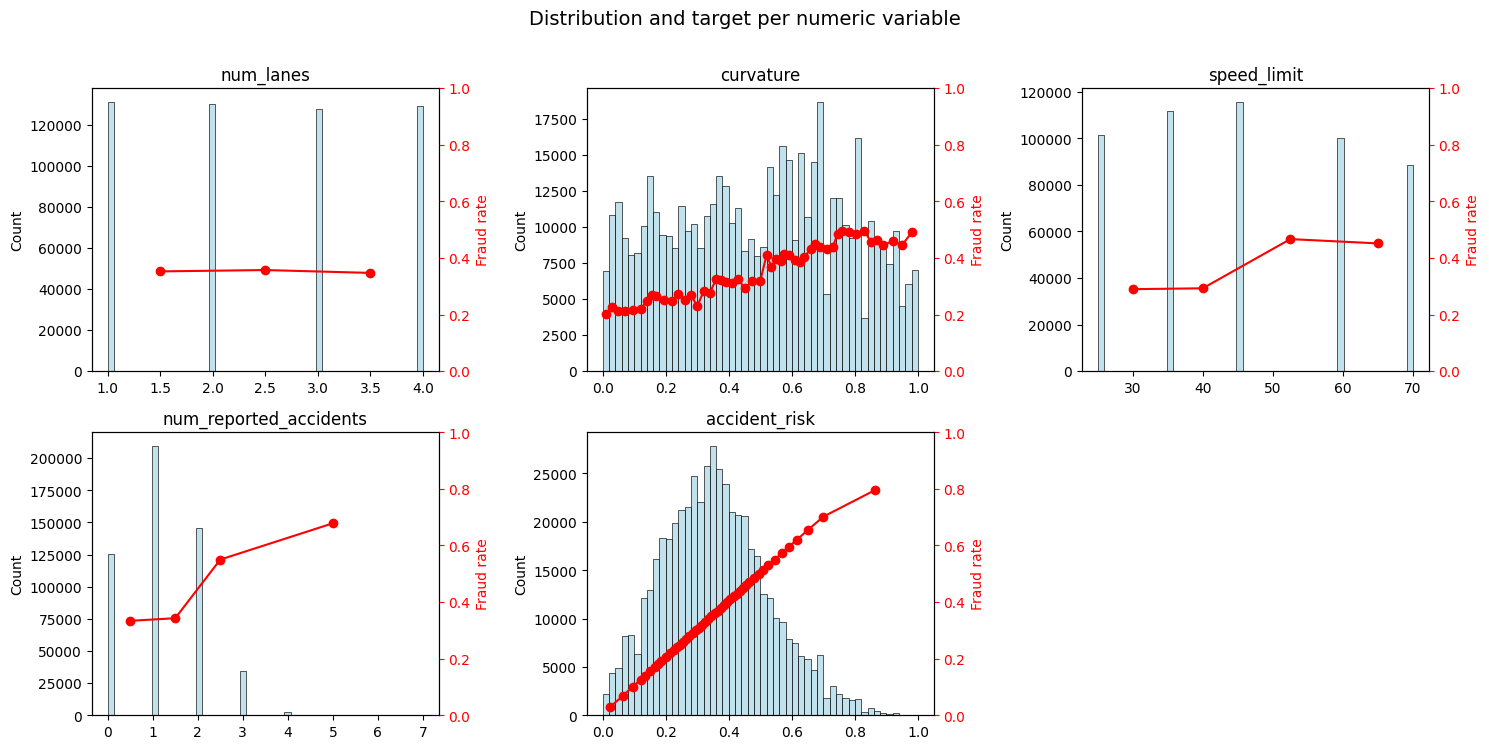

In [23]:
show_distr_num_vs_target(train)

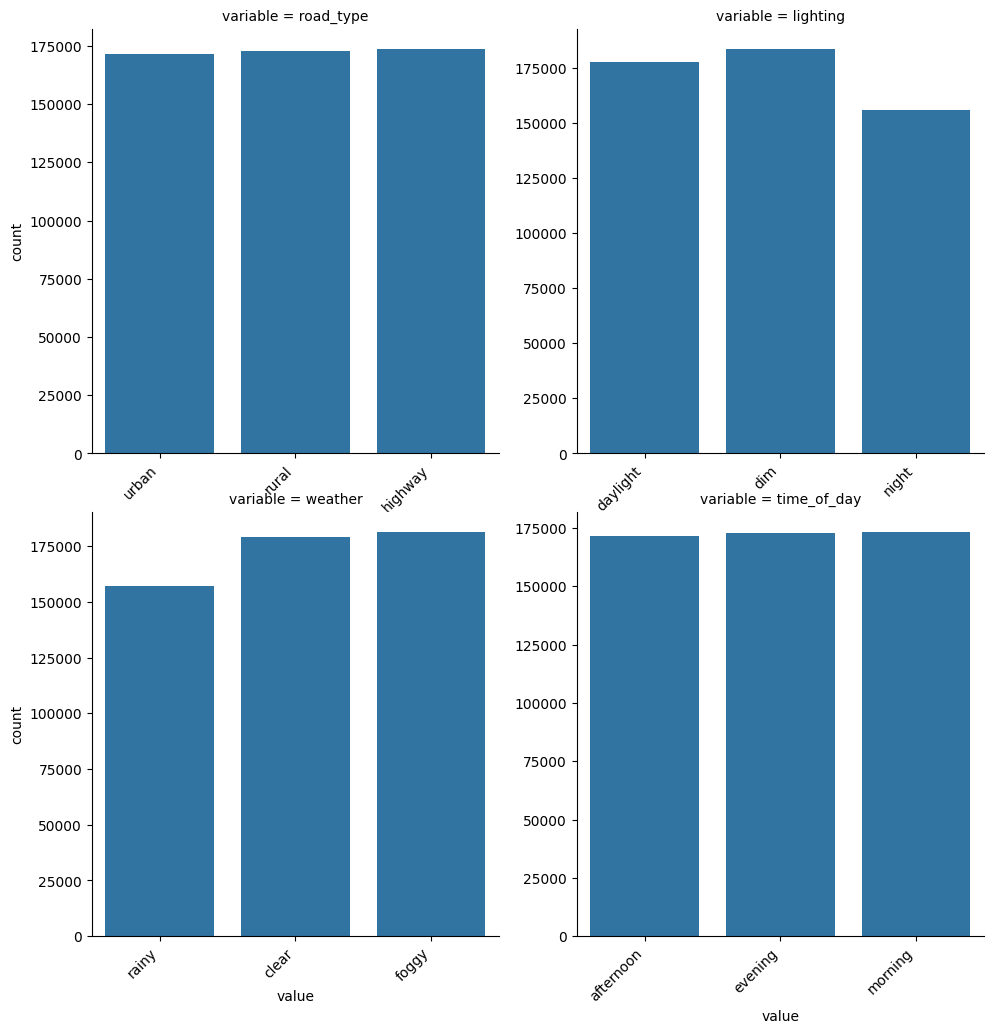

In [24]:
show_distr_cat(train)

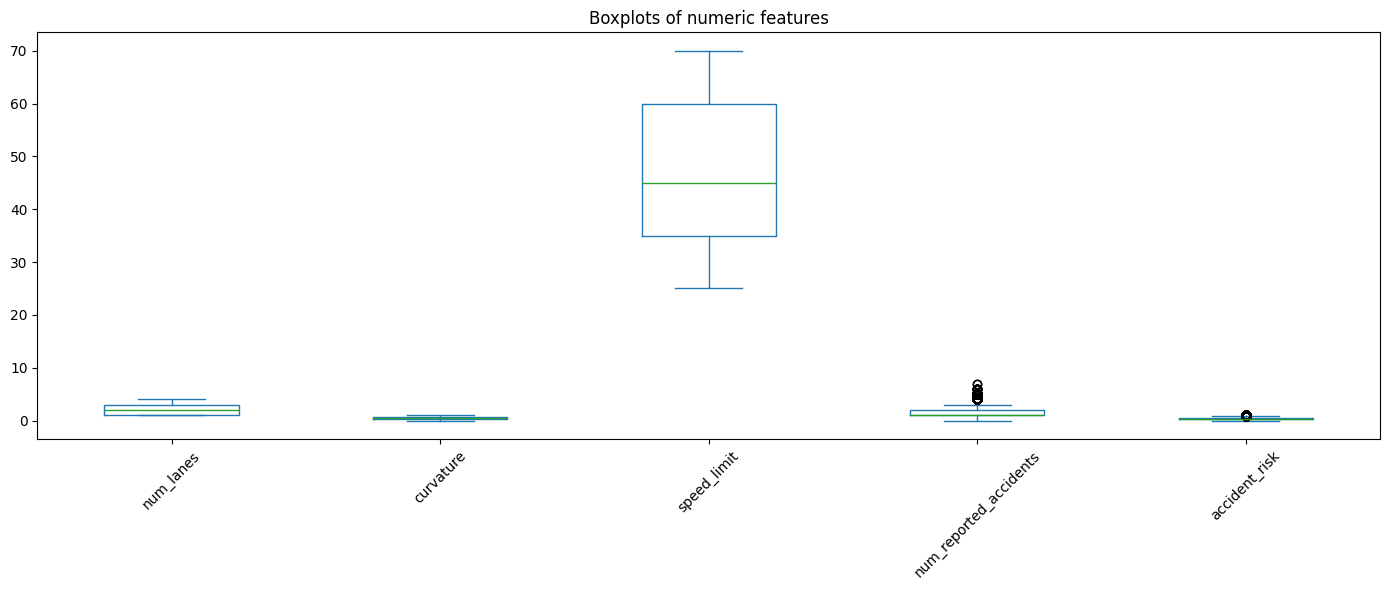

In [25]:
show_outliers(train)

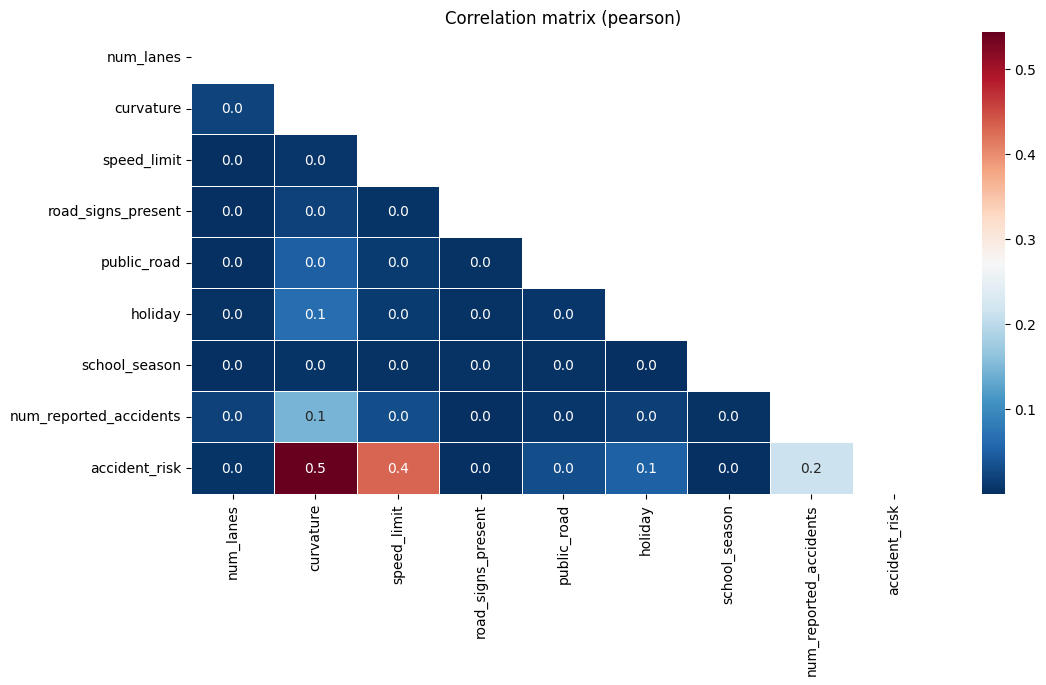

In [26]:
plot, correlations = plot_corr_mat(train)

In [27]:
correlations.head(10)

,feature_1,feature_2,abs_corr
0,accident_risk,curvature,0.543946
1,accident_risk,speed_limit,0.430898
2,accident_risk,num_reported_accidents,0.213891
3,num_reported_accidents,curvature,0.145034
4,holiday,curvature,0.063931
5,accident_risk,holiday,0.051129
6,public_road,curvature,0.048220
7,num_reported_accidents,speed_limit,0.031373
8,accident_risk,public_road,0.031032
9,curvature,num_lanes,0.020245


curvature                 0.54
speed_limit               0.43
num_reported_accidents    0.21
holiday                   0.05
public_road               0.03
num_lanes                 0.01
school_season             0.00
road_signs_present        0.00
Name: accident_risk, dtype: float64


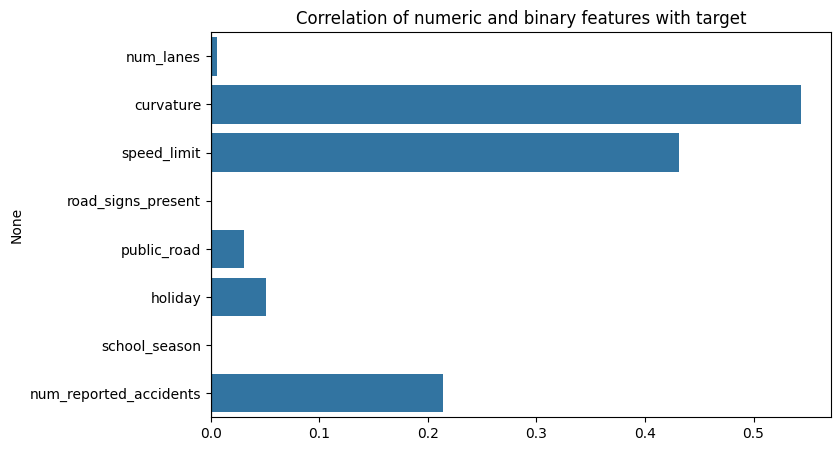

In [28]:
plot_corr_target(train)

### Model selection

In [24]:
models = {
    # 'CatBoost': CatBoostRegressor(random_state=42, verbose=0, loss_function='RMSE'),
    # 'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1)
}


In [25]:
def model_selection(models, df):
    
    results = []
    for name, model in models.items():
        if name == 'CatBoost':
            X_train, X_test, y_train, y_test, categorical_features = preprocess_dataset_catboost(df)
            model.fit(X_train, y_train, cat_features=categorical_features)

        else:
            X_train, X_test, y_train, y_test, _ = preprocess_dataset_te(df)
            model.fit(X_train, y_train)
            
        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)

        # metrics
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test  = mean_absolute_error(y_test,  y_test_pred)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test  = r2_score(y_test,  y_test_pred)

        results.append([name,
                        rmse_train, rmse_test,
                        mae_train,  mae_test,
                        r2_train,   r2_test])

    
    results_df = pd.DataFrame(results, columns=[
        "Model",
        "rmse_train", "rmse_test",
        "mae_train",  "mae_test",
        "r2_train",   "r2_test",
    ])

    # lower RMSE(test) is better
    results_df = results_df.sort_values("rmse_test", ascending=True).reset_index(drop=True)

    print("\nModel performance (sorted by test RMSE):")
    display(results_df)

    best_model_name = results_df.loc[0, "Model"]
    
    return f"Best model by RMSE test: {best_model_name}"


In [26]:
model_selection(models, train)


Model performance (sorted by test RMSE):


,Model,rmse_train,rmse_test,mae_train,mae_test,r2_train,r2_test
0,LightGBM,0.056006,0.056351,0.043563,0.04375,0.886824,0.884998


'Best model by RMSE test: LightGBM'

In [27]:
def feature_importance(models, df):
    
    X_train, _, _, _, _ = preprocess_dataset_te(df)
    feature_names = X_train.columns.tolist()

    for name, model in models.items():

        if isinstance(model, CatBoostRegressor):
            importance = model.get_feature_importance()
            label = "catboost_importance"
    
        elif isinstance(model, XGBRegressor):
            importance_dict = model.get_booster().get_score(importance_type="gain")
            importance = np.array([importance_dict.get(col, 0.0) for col in feature_names])
            label = "xgboost_gain"
    
        elif isinstance(model, LGBMRegressor):
            importance = model.booster_.feature_importance(importance_type="gain")
            label = "lightgbm_gain"
    
        else:
            print(f"Model '{name}' not supported.")
            continue

        # Return sorted DataFrame
        df_imp = (
            pd.DataFrame({"Feature": feature_names, "Importance": importance})
            .sort_values("Importance", ascending=False)
            .reset_index(drop=True)
        )
        df_imp.attrs["kind"] = label

        print(f"\n{name} — importance type: {label}")
        display(df_imp.head(15))


In [28]:
feature_importance(models, train)


LightGBM — importance type: lightgbm_gain


,Feature,Importance
0,curvature,19506.998428
1,lighting,14486.591098
2,speed_limit,13568.608220
3,weather,4065.803666
4,num_reported_accidents,1923.482025
5,holiday,10.530452
6,public_road,9.337052
7,num_lanes,3.586457
8,time_of_day,2.241738
9,road_signs_present,2.070574


### Model optimization

In [29]:
params = {
    'XGBoost': {
        'n_estimators': randint(300, 800),
        'learning_rate': uniform(0.03, 0.10),
        'max_depth': randint(3, 9),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3),
        'min_child_weight': randint(1, 10),
        'reg_alpha': uniform(0.0, 1.0),
        'reg_lambda': uniform(0.5, 2.0),
    },
    'LightGBM': {
        'n_estimators': randint(300, 800),
        'learning_rate': uniform(0.03, 0.10),
        'num_leaves': randint(31, 127),
        'max_depth': randint(-1, 12),
        'feature_fraction': uniform(0.7, 0.3),
        'bagging_fraction': uniform(0.7, 0.3),
        'min_child_samples': randint(10, 100),
        'lambda_l1': uniform(0.0, 1.0),
        'lambda_l2': uniform(0.5, 2.0),
    },
    'CatBoost': {
        'iterations': randint(400, 900),
        'depth': randint(6, 10),
        'learning_rate': uniform(0.03, 0.10),
        'l2_leaf_reg': uniform(1.0, 5.0),
        'bagging_temperature': uniform(0.0, 1.0),
    }
}


In [30]:
def hyperparam_tuning(models, df, model_type, params, n_iter=20, cv_splits=5, random_state=42, verbose=1):

    model = models[model_type]
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    scoring = 'neg_root_mean_squared_error'

    if model_type == 'CatBoost':
        X_train, X_test, y_train, y_test, cat_cols = preprocess_dataset_catboost(df)
        fit_kwargs = {'cat_features': cat_cols}
    else:
        X_train, X_test, y_train, y_test, _, _ = preprocess_dataset_te(df)
        fit_kwargs = {}

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params[model_type],
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=verbose,
        random_state=random_state,
        refit=True
    )

    if fit_kwargs:
        search.fit(X_train, y_train, **fit_kwargs)
    else:
        search.fit(X_train, y_train)

    if verbose:
        print(f"\nBest {model_type} params: {search.best_params_}")
        print(f"Best CV RMSE: {-search.best_score_:.5f}")

    return search.best_estimator_

In [31]:
# best_xgb      = hyperparam_tuning(models, train, model_type='XGBoost',  params=params, n_iter=20)
# best_lgb      = hyperparam_tuning(models, train, model_type='LightGBM', params=params, n_iter=20)
# best_catboost = hyperparam_tuning(models, train, model_type='CatBoost', params=params, n_iter=20)

# hardcoded best parameters for CatBoost because hyperparameter tuning was very time consuming(more 20 min).
best_catboost = CatBoostRegressor(
    random_state=42,
    verbose=0,
    loss_function='RMSE',
    bagging_temperature=0.15601864044243652,
    depth=8,
    iterations=614,
    l2_leaf_reg=1.2904180608409974,
    learning_rate=0.11661761457749352
)

In [32]:
X_train, X_test, y_train, y_test, target_enc = preprocess_dataset_te(train)

In [33]:
# X_train, X_test, y_train, y_test, risk_enc, feat_cols = preprocess_dataset_risk_ohe(train)

In [34]:
# X_train, X_test, y_train, y_test, risk_enc, feat_cols = preprocess_dataset_new(train)

In [42]:
best_lgb = LGBMRegressor(
    n_estimators=525,
    learning_rate=0.02401874455928918,
    num_leaves=107,
    max_depth=9,
    min_child_samples=21,
    bagging_fraction=0.7801809756094933,  
    feature_fraction=0.8177620335232247,  
    lambda_l1=0.26215199776458326,
    lambda_l2=0.15845037657532096,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

In [43]:
best_lgb.fit(X_train, y_train)

p_train_lgb = best_lgb.predict(X_train)
p_test_lgb = best_lgb.predict(X_test)

rmse_train_lgb = np.sqrt(mean_squared_error(y_train, p_train_lgb))
rmse_test_lgb = np.sqrt(mean_squared_error(y_test, p_test_lgb))

print("RMSE (train):", rmse_train_lgb)
print("RMSE (test): ", rmse_test_lgb)

# te dataset
# RMSE (train): 0.055487499219673386
# RMSE (test):  0.05618089774963958

# risk_ohe dataset
# RMSE (train): 0.05550752024337378
# RMSE (test):  0.056186532627249104

# new features +removal some features
# RMSE (train): 0.05532305537361683
# RMSE (test):  0.05622114284198746

RMSE (train): 0.055470074996659624
RMSE (test):  0.056178848241996704


In [38]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.10),
        'num_leaves': trial.suggest_int('num_leaves', 40, 110),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 40),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbose': -1,
        'n_jobs': 1 
    }

    try:
        model = LGBMRegressor(**params)
        cv = KFold(n_splits=3, shuffle=True, random_state=42)
        
        scores = cross_val_score(
            model, X_train, y_train,
            scoring='neg_root_mean_squared_error', 
            cv=cv,
            n_jobs=-1 
        )
        
        rmse = -np.mean(scores)

        if np.isnan(rmse):
            return float('inf')

        return rmse

    except Exception as e:
        print(f"An error occurred in trial {trial.number}: {e}")
        return float('inf')


# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# print(f"\nBest RMSE: {study.best_value}")
# print(f"Best params: {study.best_params}")

[I 2025-10-30 17:09:40,985] A new study created in memory with name: no-name-13804699-aecd-4de5-ab76-568450cf11cc
[I 2025-10-30 17:10:09,128] Trial 0 finished with value: 0.05610526958453053 and parameters: {'n_estimators': 755, 'learning_rate': 0.04122321971033882, 'num_leaves': 107, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.7713001232856839, 'colsample_bytree': 0.6066495489900111, 'lambda_l1': 0.1280914707214863, 'lambda_l2': 0.03906483547470105}. Best is trial 0 with value: 0.05610526958453053.
[I 2025-10-30 17:10:22,897] Trial 1 finished with value: 0.05614111019694967 and parameters: {'n_estimators': 599, 'learning_rate': 0.07728877485087081, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 34, 'subsample': 0.6912006827989464, 'colsample_bytree': 0.8467468689848132, 'lambda_l1': 3.3665445400493623, 'lambda_l2': 2.1810484444589105e-08}. Best is trial 0 with value: 0.05610526958453053.
[I 2025-10-30 17:10:28,638] Trial 2 finished with value: 0.05645711170491954 


Best RMSE: 0.05603507648796596
Best params: {'n_estimators': 525, 'learning_rate': 0.02401874455928918, 'num_leaves': 107, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.7801809756094933, 'colsample_bytree': 0.8177620335232247, 'lambda_l1': 0.26215199776458326, 'lambda_l2': 0.15845037657532096}


In [ ]:
# best_xgb.fit(X_train, y_train)

# p_train_xgb = best_xgb.predict(X_train)
# p_test_xgb = best_xgb.predict(X_test)

# rmse_train_xgb = np.sqrt(mean_squared_error(y_train, p_train_xgb))
# rmse_test_xgb = np.sqrt(mean_squared_error(y_test, p_test_xgb))

# print("RMSE (train):", rmse_train_xgb)
# print("RMSE (test): ", rmse_test_xgb)

In [ ]:
# X_train_cat, X_test_cat, y_train, y_test, categorigal_features = preprocess_dataset_catboost(train)

In [ ]:
# best_catboost.fit(X_train_cat, y_train, cat_features=categorigal_features)

# p_train_catboost = best_catboost.predict(X_train_cat)
# p_test_catboost = best_catboost.predict(X_test_cat)

# rmse_train_catboost = np.sqrt(mean_squared_error(y_train, p_train_catboost))
# rmse_test_catboost = np.sqrt(mean_squared_error(y_test, p_test_catboost))

# print("RMSE (train):", rmse_train_catboost)
# print("RMSE (test): ", rmse_test_catboost)

### Prediction for submission

In [44]:
# pipeline for preparation test dataset
test = load_dataset('data/test.csv', 'id')
display(test.head())
print(f"Shape of dataset: {test.shape}")

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
id,,,,,,,,,,,,
517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


Shape of dataset: (172585, 12)


In [45]:
final_test = preprocess_test_dataset_te(test, target_enc)
display(final_test.head())
print(f"Shape of dataset: {final_test.shape}")

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
id,,,,,,,,,,,,
517754,0.349857,2,0.34,45,0.470620,0.310137,1,1,0.351811,1,1,1
517755,0.357778,3,0.04,45,0.300148,0.386844,1,0,0.351811,1,0,0
517756,0.357778,2,0.59,35,0.300148,0.310137,1,0,0.351811,1,1,1
517757,0.350232,4,0.95,35,0.303150,0.361507,0,0,0.351811,0,0,2
517758,0.349857,2,0.86,35,0.303150,0.310137,1,0,0.354924,0,1,3


Shape of dataset: (172585, 12)


In [46]:
# final_test_cat = preprocess_test_dataset_catboost(test)
# display(final_test_cat.head())
# print(f"Shape of dataset: {final_test_cat.shape}")

In [47]:
# prediction on best_catsboost model
# test_predictions = best_catboost.predict(final_test_cat)

# prediction on best_xgb model
# test_predictions = best_xgb.predict(final_test)

# prediction on best_lgb model
test_predictions = best_lgb.predict(final_test)

In [49]:
submission = pd.Series(test_predictions,index=final_test.index, name='accident_risk')
submission.to_csv("submission.csv")